In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.test.utils import common_corpus, common_dictionary, common_texts
from gensim.models import LdaModel
from collections import Counter, defaultdict

In [2]:
np.random.seed(1)

In [3]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [4]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [5]:
dict(common_dictionary)

{0: 'computer',
 1: 'human',
 2: 'interface',
 3: 'response',
 4: 'survey',
 5: 'system',
 6: 'time',
 7: 'user',
 8: 'eps',
 9: 'trees',
 10: 'graph',
 11: 'minors'}

In [6]:
lda = LdaModel(corpus=common_corpus, num_topics=3, id2word=common_dictionary)

In [7]:
lda.get_topics()

array([[0.09991315, 0.03180536, 0.03219635, 0.08912607, 0.17471717,
        0.09523831, 0.09889168, 0.08675566, 0.03297976, 0.03802519,
        0.11181334, 0.10853791],
       [0.11099348, 0.19903353, 0.11578164, 0.03308505, 0.03267179,
        0.20439455, 0.03299609, 0.03511733, 0.11463977, 0.04719991,
        0.03913659, 0.03495036],
       [0.03130063, 0.02087262, 0.07347195, 0.08797028, 0.03108724,
        0.0874393 , 0.08150668, 0.1444235 , 0.07367393, 0.16928692,
        0.12514158, 0.07382545]], dtype=float32)

In [8]:
topic_names = [lda.id2word[i] for i in range(len(lda.id2word))]

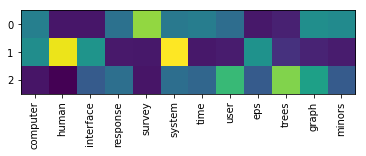

In [9]:
fig, ax = plt.subplots()
ax.imshow(lda.get_topics())
ax.set_xticks(np.arange(len(lda.id2word)))
ax.set_xticklabels(topic_names, rotation = 'vertical')
None

In [10]:
lda.get_topics().sum(axis=1)

array([1.       , 1.       , 1.0000001], dtype=float32)

In [11]:
lda.print_topics()

[(0,
  '0.175*"survey" + 0.112*"graph" + 0.109*"minors" + 0.100*"computer" + 0.099*"time" + 0.095*"system" + 0.089*"response" + 0.087*"user" + 0.038*"trees" + 0.033*"eps"'),
 (1,
  '0.204*"system" + 0.199*"human" + 0.116*"interface" + 0.115*"eps" + 0.111*"computer" + 0.047*"trees" + 0.039*"graph" + 0.035*"user" + 0.035*"minors" + 0.033*"response"'),
 (2,
  '0.169*"trees" + 0.144*"user" + 0.125*"graph" + 0.088*"response" + 0.087*"system" + 0.082*"time" + 0.074*"minors" + 0.074*"eps" + 0.073*"interface" + 0.031*"computer"')]

## Trying out collapsed gibbs

In [12]:
vocab_size = max(max(1 + v[0] for v in doc) for doc in common_corpus)
vocab_size

12

In [13]:
doc_lengths = [sum(x[1] for x in doc) for doc in common_corpus]
corpus_length = sum(doc_lengths)

In [14]:
doc_lengths

[3, 6, 4, 4, 3, 1, 2, 3, 3]

In [15]:
corpus_length

29

In [16]:
K = 3

In [17]:
# Initialization
Z = [np.random.choice(K, size=L) for L in doc_lengths]
Z

[array([0, 2, 2]),
 array([0, 1, 1, 2, 1, 2]),
 array([0, 1, 1, 0]),
 array([1, 1, 2, 2]),
 array([0, 2, 0]),
 array([2]),
 array([0, 2]),
 array([2, 0, 2]),
 array([0, 2, 0])]

In [18]:
burn_in = 10
lag = 20
num_samples = 100

In [19]:
import copy

In [20]:
import itertools

In [21]:
def flatten_one_level(L):
    return list(itertools.chain.from_iterable(L))

In [22]:
flatten_one_level([[1,2,3],[4,5,6],[7,8],[],[9]])

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
from tqdm import tqdm, tnrange, tqdm_notebook

In [112]:
class CollapsedGibbs(object):
    def fit(self,
            corpus,
            num_topics,
            vocab_size,
            burn_in = 10,
            lag = 20,
            num_samples = 100,
            alpha = 1.0,
            beta = 1.0,
            update_alpha_every = 0):
        alpha = np.broadcast_to(alpha, (num_topics,))
        beta = np.broadcast_to(beta, (vocab_size,))
        beta_sum = beta.sum()
        lag = max(1, lag)
        burn_in = max(0, burn_in)
        num_samples = max(0, num_samples)
        update_alpha_every = max(0, update_alpha_every)

        self.alpha_original = alpha.copy()

        doc_lengths = [sum(x[1] for x in doc) for doc in corpus]
        blank_counter = lambda: np.zeros((num_topics,), dtype='int')
        topic_counts = {
            "overall": blank_counter(),
            "by_doc": defaultdict(blank_counter),
            "by_vocab": defaultdict(blank_counter),
            "by_doc_vocab": defaultdict(blank_counter),
        }

        def sample_once(doc_index, vocab_index, topic_old):
            A = topic_counts["by_doc"][doc_index]
            B = topic_counts["by_vocab"][vocab_index]
            C = topic_counts["overall"]
            D = topic_counts["by_doc_vocab"][doc_index, vocab_index]
            if topic_old is not None:
                for x in [A, B, C, D]:
                    x[topic_old] -= 1
            probs = (alpha + A) * (beta[vocab_index] + B) / (beta_sum + C)
            probs /= probs.sum()
            topic_new = np.random.choice(num_topics, p = probs)
            for x in [A, B, C, D]:
                x[topic_new] += 1                
        
        for di, doc in enumerate(tqdm_notebook(corpus, desc = "Initializing")):
            for v, c in doc:
                for pi in range(c):
                    sample_once(doc_index = di, vocab_index = v, topic_old = None)
        del di, doc, v, c, pi
        
        self.samples = []
        for i in tnrange(burn_in + lag * num_samples, desc = "Training"):
            for di, doc in enumerate(tqdm_notebook(corpus, desc = "Current iteration", leave = False)):
                for v, vc in doc:
                    current_counts = topic_counts["by_doc_vocab"][di, v].copy()
                    for t, tc in enumerate(current_counts):
                        for j in range(tc):
                            sample_once(doc_index = di, vocab_index = v, topic_old = t)
            update_alpha = (update_alpha_every > 0) and (i % update_alpha_every == 0)
            if update_alpha:
                # Compute moments of observed probabilities, and estimate new alpha
                # Source: Thomas P. Minka, "Estimating a Dirichlet distribution" (2000)
                num_docs = len(corpus)
                m1 = np.zeros(num_topics)
                m2 = np.zeros(num_topics)
                for di, t in topic_counts["by_doc"].items():
                    p = t.astype('float') / t.sum()
                    m1 += p
                    m2 += p ** 2
                m1 /= num_docs
                m2 /= num_docs
                if m2[0] != m1[0] ** 2:
                    s = (m1[0] - m2[0]) / (m2[0] - m1[0] ** 2)  # Minka, eqn (21)
                    alpha = m1 * s

            if i >= burn_in and (i - burn_in) % lag == 0:
                sample = copy.deepcopy(topic_counts)
                sample["alpha"] = alpha.copy()
                self.samples.append(sample)

        self.corpus = copy.deepcopy(corpus)
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.alpha = alpha.copy()
        self.beta = beta.copy()

    def topics_by_sample(self):
        counts = np.zeros((len(self.samples), self.num_topics, self.vocab_size))
        for si, sample in enumerate(self.samples):
            for (di, v), topic_count in sample["by_doc_vocab"].items():
                counts[si, :, v] += topic_count
        numer = counts + self.beta[np.newaxis, np.newaxis, :]
        denom = counts.sum(axis = 2, keepdims = True) + self.beta.sum()
        return numer / denom
        #return counts / counts.sum(axis = 2, keepdims = True)
        
    def cooccurrence_by_sample(self):
        num_samples = len(self.samples)
        result = np.zeros((num_samples, self.num_topics, self.num_topics))
        for si, sample in enumerate(self.samples):
            for di, topic_count in sample["by_doc"].items():
                probs = topic_count / topic_count.sum()
                result[si, :, :] += np.outer(probs, probs)
        result /= result.sum(axis = (1, 2), keepdims = True)
        return result

In [25]:
np.random.seed(1)

In [26]:
result = CollapsedGibbs()
result.fit(common_corpus, num_topics = 3, vocab_size = vocab_size, num_samples = 100, update_alpha_every = 1)
len(result.samples)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


100

In [27]:
T = result.topics_by_sample()

In [28]:
nan_indices = np.array(np.where(np.isnan(T)))
if nan_indices.size > 0:
    example_index = nan_indices[0, 0]
else:
    example_index = 0

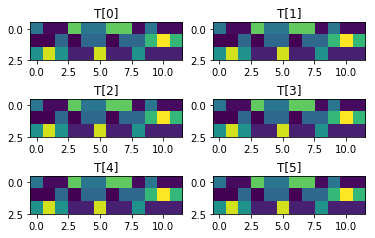

In [29]:
nr, nc = 3, 2
fig, ax = plt.subplots(nr, nc)
for i in range(nr * nc):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

In [30]:
sums = T.sum(axis=2)
np.min(sums), np.max(sums)

(0.9999999999999998, 0.9999999999999999)

In [31]:
topics = T.mean(axis = 0)

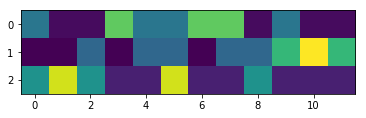

In [32]:
plt.imshow(topics);

In [33]:
[common_dictionary[i] for i in range(vocab_size)]

['computer',
 'human',
 'interface',
 'response',
 'survey',
 'system',
 'time',
 'user',
 'eps',
 'trees',
 'graph',
 'minors']

In [34]:
corpus_word_counts = Counter()
for doc in common_corpus:
    for w, c in doc:
        corpus_word_counts[w] += c
corpus_word_counts

Counter({0: 2,
         1: 2,
         2: 2,
         3: 2,
         4: 2,
         5: 4,
         6: 2,
         7: 3,
         8: 2,
         9: 3,
         10: 3,
         11: 2})

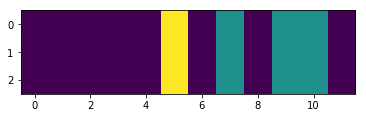

In [35]:
unif_topics = np.broadcast_to([corpus_word_counts[i] for i in range(vocab_size)], topics.shape).astype('float')
unif_topics /= unif_topics.sum(axis = 1, keepdims = True)
plt.imshow(unif_topics);

## Experiments with Griffiths-Steyvers square-image data generation

In [36]:
np.random.seed(1)

In [37]:
from sim_data import GriffithsSteyversSampler

In [38]:
sampler = GriffithsSteyversSampler(num_docs = 1000, words_per_doc = 100, dimension = 5, alpha = 0.1)
sampler.sample()
None

100%|██████████| 1000/1000 [00:06<00:00, 146.47it/s]


In [39]:
docs_to_display = 50

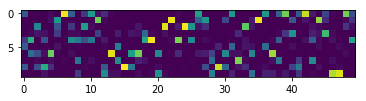

In [40]:
plt.imshow(np.array(sampler.doc_topic_mixtures)[:docs_to_display, :].T);

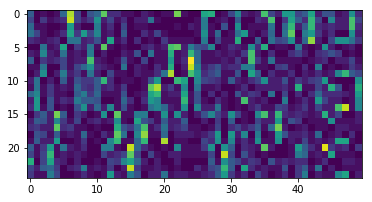

In [41]:
plt.imshow(sampler.data.toarray()[:docs_to_display, :].T);

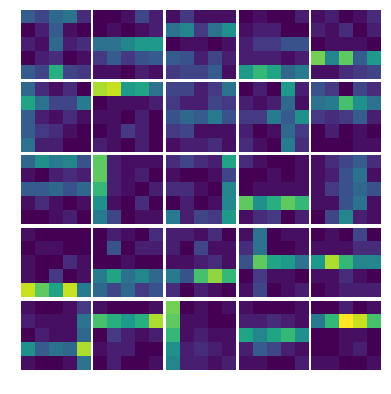

In [42]:
sq = 5
fig, ax = plt.subplots(sq, sq, figsize = (5, 5))
fig.subplots_adjust(hspace = 0.05, wspace = 0.05, left = 0, right = 1, top = 1, bottom = 0)
max_count = sampler.data[:docs_to_display, :].max()
for i in range(sq):
    for j in range(sq):
        n = i * sq + j
        if n < docs_to_display:
            X = sampler.data[n, :].toarray().reshape(sampler.dimension, sampler.dimension)
            ax[i, j].imshow(X, vmin = 0, vmax = max_count)
        ax[i, j].axis('off')

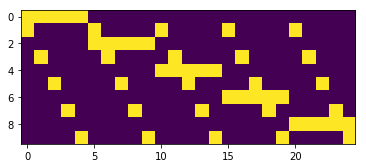

In [43]:
plt.imshow(sampler.topics);

In [44]:
# %%time
# lda = LdaModel(
#     corpus=sampler.gensim_corpus,
#     num_topics=sampler.num_topics,
#     passes=20)

In [45]:
# topics = lda.get_topics()

In [46]:
# plt.imshow(topics);

In [47]:
np.random.seed(1)

In [48]:
result = CollapsedGibbs()
result.fit(
    corpus = sampler.gensim_corpus,
    num_topics = sampler.num_topics,
    vocab_size = sampler.vocab_size,
    num_samples = 20,
    lag = 1,
    burn_in = 10)
len(result.samples)

20

In [49]:
T = result.topics_by_sample()

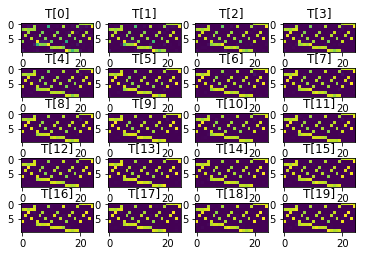

In [50]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

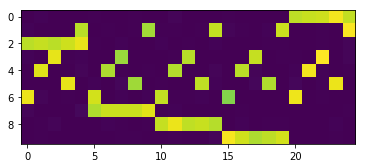

In [51]:
plt.imshow(T[-1]);

In [52]:
%%time
cooccur_by_sample = result.cooccurrence_by_sample()

CPU times: user 297 ms, sys: 6.16 ms, total: 303 ms
Wall time: 314 ms


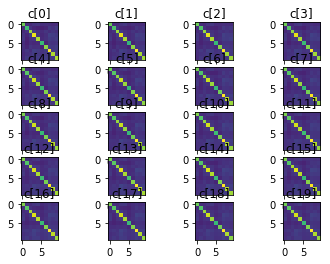

In [53]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(cooccur_by_sample[i], vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

In [54]:
from sim_data import topics_griffiths_steyvers

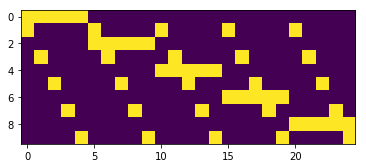

In [55]:
plt.imshow(topics_griffiths_steyvers(10));

### Try combining G.S. topics with tree-based model

In [56]:
import networkx as nx

In [57]:
from example_graphs import make_tree
from utils import nice_tree_plot, without_diag
from sim_data import HPAM2Sampler, get_alpha, topics_griffiths_steyvers
from functools import partial

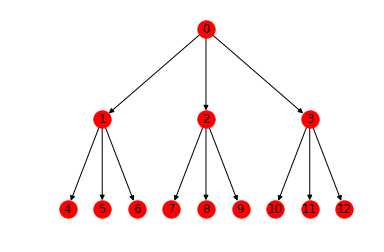

In [58]:
tree = make_tree([3,3])
nice_tree_plot(tree)

In [59]:
exact_topics = topics_griffiths_steyvers(tree.number_of_nodes())

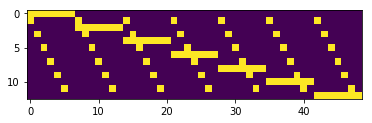

In [60]:
plt.imshow(exact_topics);

In [61]:
topic_func = lambda n: exact_topics[n, :]

In [104]:
np.random.seed(1)

In [105]:
h_sampler = HPAM2Sampler(
    tree,
    num_docs = 10000,
    words_per_doc = 1000,
    vocab_size = exact_topics.shape[1],
    topic_dirichlet = None,
    topic_func = topic_func,
    alpha_func = partial(get_alpha, scale=0.1)
)

In [106]:
h_sampler.sample();

100%|██████████| 10000/10000 [16:39<00:00, 10.01it/s]


In [107]:
tree_corpus = []
for doc in h_sampler.docs:
    ctr = Counter(doc)
    doc_short = [(k, v) for k, v in ctr.items()]
    tree_corpus.append(doc_short)
len(tree_corpus)

10000

In [113]:
np.random.seed(3)
# NOTE: quality of results seem to have a lot of variance (to see this, try changing the random seed)

In [114]:
#custom_alpha = 1.3 ** np.arange(h_sampler.g.number_of_nodes())[::-1]

#custom_alpha = np.ones(h_sampler.g.number_of_nodes())
#custom_alpha[0] = 9
#custom_alpha[[1,2,3]] = 3

In [115]:
#plt.bar(np.arange(len(custom_alpha)), custom_alpha);

In [116]:
result = CollapsedGibbs()
result.fit(
    corpus = tree_corpus,
    num_topics = h_sampler.g.number_of_nodes(),
    vocab_size = h_sampler.vocab_size,
    #alpha = custom_alpha,
    num_samples = 3,
    lag = 1,
    burn_in = 3,
    update_alpha_every = 1)
len(result.samples)

3

In [117]:
T = result.topics_by_sample()

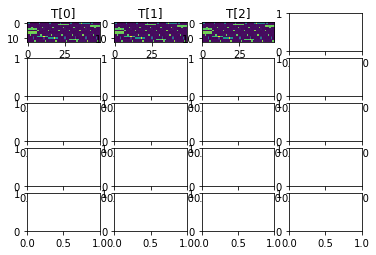

In [118]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

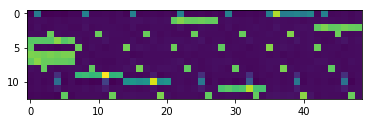

In [119]:
plt.imshow(T[-1]);

In [120]:
%%time
cooccur_by_sample = result.cooccurrence_by_sample()

CPU times: user 442 ms, sys: 3.36 ms, total: 446 ms
Wall time: 445 ms


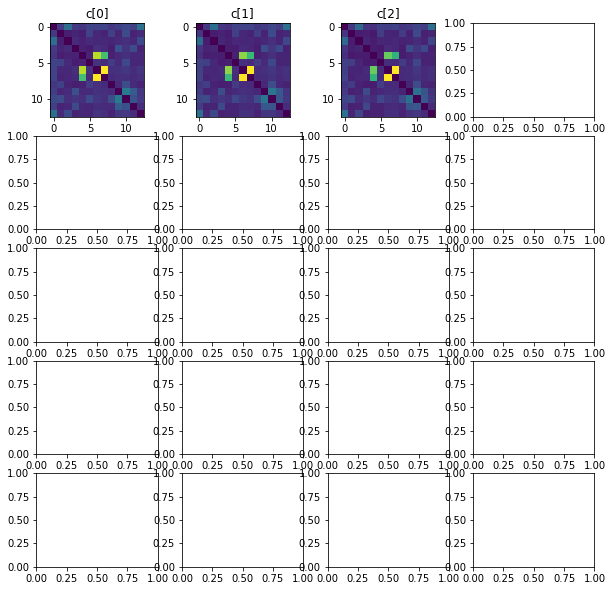

In [121]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc, figsize=(10,10))
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(without_diag(cooccur_by_sample[i]), vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

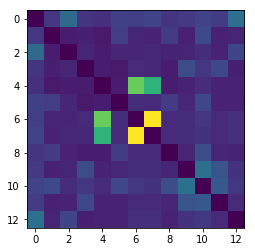

In [122]:
plt.imshow(without_diag(cooccur_by_sample[-1]), vmin=0);

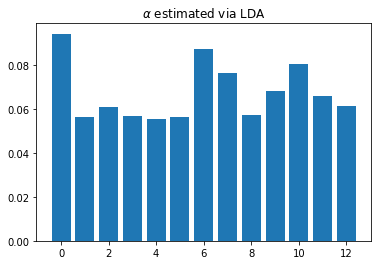

In [123]:
fig, ax = plt.subplots()
ax.bar(np.arange(result.alpha.shape[0]), result.alpha)
ax.set_title("$\\alpha$ estimated via LDA")
None

In [124]:
from utils import permute_square, invert_permutation

In [125]:
from tree_extraction import Aho

In [126]:
np.histogram(np.random.choice(10, 1000), bins = np.arange(10+1))

(array([111,  97, 101,  93, 104,  99, 103,  95,  97, 100]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [127]:
from compute_pam import compute_combo_tensor

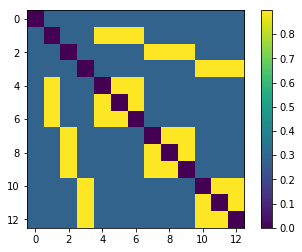

In [128]:
# True cooccurrence and ratio matrix
cooccur_true = compute_combo_tensor(g = h_sampler.g, alpha_func = partial(get_alpha, scale=0.1))

plt.imshow(without_diag(Aho.get_ratio_matrix(cooccur_true)));
plt.colorbar();

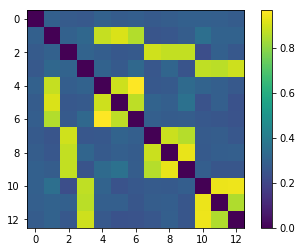

In [129]:
# Empirical cooccurrence and ratio matrix
cooccur_empirical = np.zeros(cooccur_by_sample[-1].shape)
for nodes in h_sampler.doc_nodes:
    p = np.histogram(nodes, bins = np.arange(1 + h_sampler.g.number_of_nodes()))[0]
    p = p.astype('float') / p.sum()
    cooccur_empirical += np.outer(p, p)
cooccur_empirical /= cooccur_empirical.sum()

plt.imshow(without_diag(Aho.get_ratio_matrix(cooccur_empirical)));
plt.colorbar();

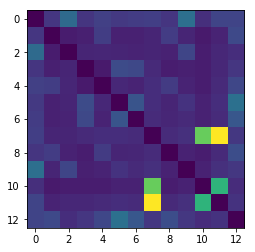

In [130]:
perm = [0, 1, 2, 3, 5, 9, 11, 6, 8, 12, 4, 7, 10]
plt.imshow(permute_square(without_diag(cooccur_by_sample[-1]), perm));

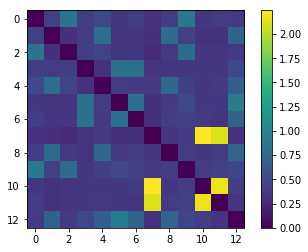

In [131]:
plt.imshow(permute_square(without_diag(Aho.get_ratio_matrix(cooccur_by_sample[-1])), perm));
plt.colorbar();

In [132]:
np.max(np.abs(cooccur_by_sample[-1] - cooccur_by_sample[-1].T))

0.0

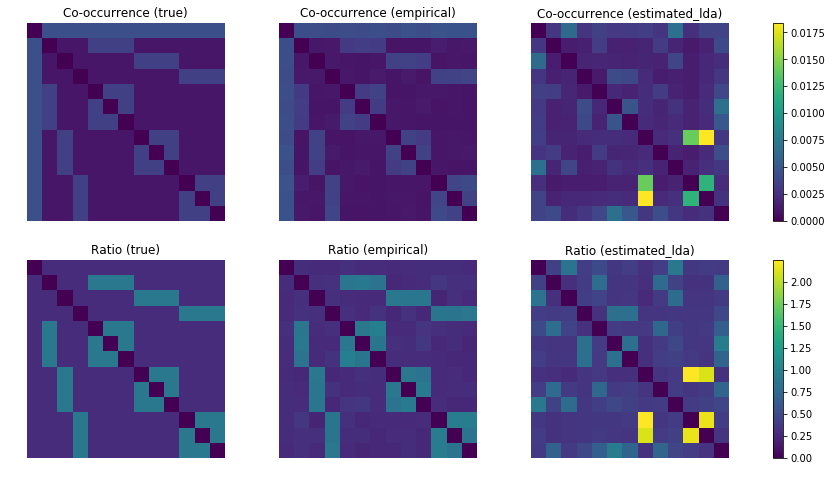

In [133]:
cooccur_all = [
    ("true", cooccur_true),
    ("empirical", cooccur_empirical),
    ("estimated_lda", permute_square(cooccur_by_sample[-1], perm=perm)),
]

ratio_all = [(name, Aho.get_ratio_matrix(m)) for name, m in cooccur_all]

max_cooccur = np.max([np.max(without_diag(m)) for name, m in cooccur_all])
max_ratio = np.max([np.max(without_diag(m)) for name, m in ratio_all])

fig, ax = plt.subplots(2, len(cooccur_all), figsize=(16, 8))
for i, (name, m) in enumerate(cooccur_all):
    ax[0, i].imshow(without_diag(m), vmin=0, vmax=max_cooccur)
    ax[0, i].set_title("Co-occurrence ({})".format(name))
    ax[0, i].axis('off')
    ax[1, i].imshow(without_diag(ratio_all[i][1]), vmin=0, vmax=max_ratio)
    ax[1, i].set_title("Ratio ({})".format(name))
    ax[1, i].axis('off')

fig.colorbar(ax[0, 0].get_images()[0], ax = [ax[0, i] for i in range(len(cooccur_all))]);
fig.colorbar(ax[1, 0].get_images()[0], ax = [ax[1, i] for i in range(len(cooccur_all))]);

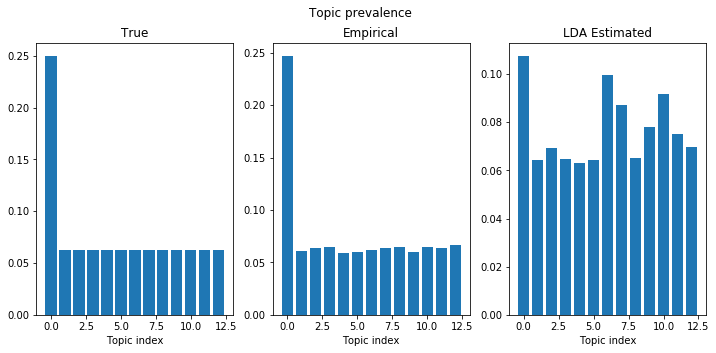

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].bar(np.arange(cooccur_true.shape[0]), cooccur_true.sum(axis=0))
ax[0].set_xlabel("Topic index")
ax[0].set_title("True")
ax[1].bar(np.arange(cooccur_true.shape[0]), cooccur_empirical.sum(axis=0))
ax[1].set_xlabel("Topic index")
ax[1].set_title("Empirical")
ax[2].bar(np.arange(cooccur_true.shape[0]), cooccur_by_sample[-1].sum(axis=0));
ax[2].set_xlabel("Topic index")
ax[2].set_title("LDA Estimated")
fig.suptitle("Topic prevalence")
None

In [135]:
true_prevalence = cooccur_true.sum(axis=0)
true_prevalence[0] / true_prevalence[1]

4.0

In [136]:
tree_extracted = Aho.extract(cooccur_by_sample[-1])

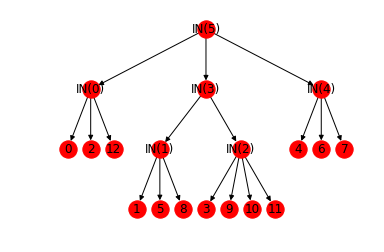

In [137]:
nice_tree_plot(tree_extracted)

In [138]:
r = without_diag(cooccur_by_sample[-1])
imax = np.argmax(r)
coordmax = np.unravel_index(imax, r.shape)
rmax = r[coordmax]
rmax, coordmax

(0.018379683100000065, (6, 7))

In [139]:
def diagnose_separation(cooccur, A, B, C, threshold = 0.0):
    ratio_matrix = Aho.get_ratio_matrix(cooccur)
    result = []
    for a in A:
        for b in B:
            if a == b:
                continue
            for c in C:
                if a == c or b == c:
                    continue
                strength = ratio_matrix[a, b] - max(ratio_matrix[a, c], ratio_matrix[b, c])
                if strength > 0:
                    result.append((a, b, c, strength))
    return sorted(result, key=lambda x: -x[3])

In [140]:
diagnose_separation(cooccur_by_sample[-1], [1,5,9,11], [2,6,8,12], [3,4,7,10])

[(1, 8, 4, 0.4314249985112364),
 (5, 8, 3, 0.4079040092003925),
 (1, 8, 7, 0.3966977308176256),
 (1, 8, 3, 0.3938561582983676),
 (5, 8, 4, 0.38884716548142767),
 (5, 8, 7, 0.36479062031095444),
 (9, 12, 4, 0.09017322610323458),
 (5, 2, 4, 0.08219196491781128),
 (9, 12, 7, 0.06707636558728952),
 (5, 2, 7, 0.06405012569218932),
 (1, 8, 10, 0.05911255133998494),
 (5, 12, 3, 0.049827658673498865),
 (5, 6, 3, 0.037411581345880796),
 (1, 12, 3, 0.03645877901209138),
 (5, 2, 3, 0.03406777665494559),
 (1, 12, 4, 0.031692143773062564),
 (11, 8, 4, 0.029981423682300223),
 (5, 8, 10, 0.027205440833313776),
 (11, 12, 4, 0.022129850617220725),
 (9, 8, 4, 0.016839514568520564),
 (11, 8, 7, 0.015975382431819507),
 (5, 12, 4, 0.014085490246025845),
 (11, 2, 7, 0.013659387342949747),
 (1, 12, 7, 0.008595283257117503)]

In [141]:
import matplotlib as mpl

In [142]:
def highlight_triplet(M, i, j, k, override_title = True, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(M, **kwargs)
    results = []
    for i1, i2 in [(i, j), (j, k), (i, k)]:
        a = min(i1, i2)
        b = max(i1, i2)
        results.append((a, b, M[a, b]))
    results = sorted(results, key = lambda x: x[-1])
    for r_index, (i1, i2, Mval) in enumerate(results):
        color = 'red' if r_index == len(results) - 1 else 'white'
        ax.add_patch(mpl.patches.Rectangle(xy = (i1-0.5, i2-0.5),
            width = 1, height = 1, fill = False, edgecolor = color))
    if override_title:
        title = "Among [{}, {}, {}], max entry at ({}, {})".format(i, j, k, results[-1][0], results[-1][1])
        ax.set_title(title)

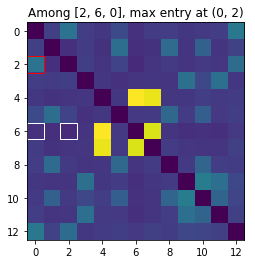

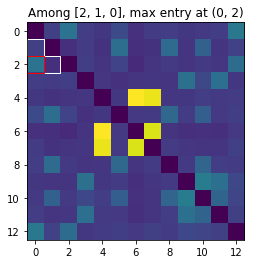

In [143]:
highlight_triplet(without_diag(Aho.get_ratio_matrix(cooccur_by_sample[-1])), 2, 6, 0)
highlight_triplet(without_diag(Aho.get_ratio_matrix(cooccur_by_sample[-1])), 2, 1, 0)

## Quick way to reload without rerunning everything

In [96]:
from importlib import reload
import sim_data
reload(sim_data)
del sim_data